# Sentiment Analysis en YouTube

## Introducción
El siguiente documento emplea diversos modelos de clasificación de texto entrenados con la base de datos de Twitter para realizar dicha clasificación en comentarios de videos de YouTube. La intención de dicho programa no es de analizar el rendimiento de estos modelos (esto se realizó anteriormente obteniendo valores de accuracy cercana al 80%), sino de analizar la relación entre el porcentaje de comentarios positivos (100 * positivos / (postivios + negativos)) y el mismo de likes (100 * likes / (likes + dislikes)).

## Resultados
Se esperaba obtener una tendencia relativamente lineal que demostrase algún grado de correlación. No obstante, no se encontró ninguna tendencia o relación entre ambas variables, aunque esto no necesariamente significa que no valió la pena el desarrollo del modelo, puesto a que se pueden realizar diversas observaciones sobre los resultados (como una mayor tendencia en comentarios negativos que dislikes), el tipo de texto en los comentarios (como el hecho que son más cortos que Twitter y tienen una peor redacción y claridad), y acerca de los propios modelos (como las limitaciones de emplear algoritmos entrenados en una red social en otra).

In [1]:
# Importa las librerias (algunas no se usan pero nunca esta de mas)
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import csv
import nltk
from nltk.tokenize import *
from nltk.corpus import stopwords #2
from nltk.stem import PorterStemmer #3
from nltk.corpus import state_union #4
from nltk.tokenize import PunktSentenceTokenizer #4
from nltk.stem import WordNetLemmatizer #8
from nltk.corpus import wordnet #10
import random # 11
from nltk.corpus import movie_reviews #11
import pickle #14
from nltk.classify.scikitlearn import SklearnClassifier #15
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB #15
from sklearn.linear_model import LogisticRegression, SGDClassifier #15
from sklearn.svm import SVC, LinearSVC, NuSVC #15
from nltk.classify import ClassifierI #16
from statistics import mode #16
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Carga los Pickles
save_class = open("pickle/naive.pickle", "rb")
classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/mnb.pickle", "rb")
MNB_classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/bernoulli.pickle", "rb")
BernoulliNB_classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/logistic.pickle", "rb")
LogisticRegression_classifier = pickle.load(save_class)
save_class.close()

save_class = open("pickle/sgd.pickle", "rb")
SGDClassifier_classifier = pickle.load(save_class)
save_class.close()

save_word = open("pickle/word_tweets.pickle", "rb")
word_features = pickle.load(save_word)
save_word.close()

archivo = open("pickle/Info.pickle", "rb")
info = pickle.load(archivo)
archivo.close()

archivo = open("pickle/Comentarios.pickle", "rb")
comentarios = pickle.load(archivo)
archivo.close()

archivo = open("pickle/IDs.pickle", "rb")
IDs = pickle.load(archivo)
archivo.close()

archivo = open("pickle/Resultados.pickle", "rb")
dfFinal = pickle.load(archivo)
archivo.close()

archivo = open("pickle/ListaFinal.pickle", "rb")
infoFinal = pickle.load(archivo)
archivo.close()

# Crea el clasificador por votos
class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
            respuesta = 0
            if "Positive" in votes:
                respuesta = 1
        return respuesta
    
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

clasificador = VoteClassifier(
    classifier, 
    MNB_classifier, 
    BernoulliNB_classifier,
    LogisticRegression_classifier,
    SGDClassifier_classifier)

# Crea la funcion que encuentra los features
def find_features(document):
    document = str(document)
    words = document.split()
    features = {}
    for w in word_features:
        features[w] = (w in words)
    
    return features

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DictVectorizer from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator BernoulliNB from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code o

In [2]:
# Abrir los datos de videos (ignorar si se cargaron los pickles)
dfVids = pd.read_csv('USvideos.csv',encoding = 'latin-1',header=None,error_bad_lines=False)
# Label the columns of our dataset
dfVids.columns = ['video_id','title','channel_title','category_id','tags','views','likes','dislikes','comment_total','thumbnail_link','date']
# Drop the columns that we won't need
dfVids = dfVids.drop(['channel_title','category_id','tags','comment_total','thumbnail_link','date'], axis=1)

# Abrir los datos de comentarios (ignorar si se cargaron los pickles)
dfComs = pd.read_csv('UScomments.csv',encoding = 'latin-1',header=None,error_bad_lines=False)
# Label the columns of our dataset
dfComs.columns = ['video_id','comment_text','likes','replies']
# Drop the columns that we won't need
dfComs = dfComs.drop(['likes','replies'], axis=1)

b'Skipping line 2401: expected 11 fields, saw 21\nSkipping line 2800: expected 11 fields, saw 21\nSkipping line 5297: expected 11 fields, saw 12\nSkipping line 5299: expected 11 fields, saw 12\nSkipping line 5300: expected 11 fields, saw 12\nSkipping line 5301: expected 11 fields, saw 12\n'
b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Filtra los videos con pocos comentarios (ignorar si se cargaron los pickles)
comentarios_minimos = 200
ID = dfComs[['video_id']]
dfComs = dfComs[ID.replace(ID.stack().value_counts()).gt(comentarios_minimos).all(1)]
print(len(dfComs.index))

frecuencias = dfComs.groupby("video_id").count()
print(len(frecuencias.index))
frecuencias#.at["XpVt6Z1Gjjo","comment_text"]

584845
1344


,comment_text
video_id,
-6Zc8Co2H3w,400
-AJyaVduxCc,291
-B9z3az6Axc,500
-CEuQhqNzz4,234
-DGXHMOhXAw,400
...,...
zkIrbVycAeM,599
zmg9tVaMVd4,498
zqE-ultsWt0,500


In [8]:
# Crea lista (unicos) de los IDs a usar (ignorar si se cargaron los pickles)
IDs = list(dfComs["video_id"])
IDs = list(dict.fromkeys(IDs))

# Crea diccionarios con los datos de cada videos y otro con sus comentarios (ignorar si se cargaron los pickles)
info = {}
comentarios = {}

for i in range(len(IDs)):
    info[IDs[i]] = dfVids.loc[dfVids["video_id"] == IDs[i]].iloc[[-1]][["title","views","likes","dislikes"]].values.tolist()[0]
    lista_de_listas = dfComs.loc[dfComs["video_id"] == IDs[i]][["comment_text"]].values.tolist()
    comentarios[IDs[i]] = [item for sublist in lista_de_listas for item in sublist]

guardar = open("IDs.pickle","wb")
pickle.dump(IDs, guardar)
guardar.close()

guardar = open("Info.pickle","wb")
pickle.dump(info, guardar)
guardar.close()

guardar = open("Comentarios.pickle","wb")
pickle.dump(comentarios, guardar)
guardar.close()

In [27]:
# Crea una lista con toda la informacion de los videos (ignorar si se cargaron los pickles)
infoFinal = []

for i in range(100):
    clasificados = [clasificador.classify(find_features(i)) for i in comentarios[IDs[i]]]
    positivos = sum(clasificados)
    negativos = len(clasificados) - positivos
    
    nuevo = list(info[IDs[i]])
    nuevo[1:] = [int(x) for x in nuevo[1:]]
    nuevo.extend([positivos,negativos])
    nuevo.append(100 * nuevo[2] / (nuevo[2] + nuevo[3]))
    nuevo.append(100 * nuevo[4] / (nuevo[4] + nuevo[5]))
    infoFinal.append(nuevo)
    
    #if i % 5 == 0:
        #print(i)

'infoFinal = []\n\nfor i in range(100):\n    clasificados = [clasificador.classify(find_features(i)) for i in comentarios[IDs[i]]]\n    positivos = sum(clasificados)\n    negativos = len(clasificados) - positivos\n    \n    nuevo = list(info[IDs[i]])\n    nuevo[1:] = [int(x) for x in nuevo[1:]]\n    nuevo.extend([positivos,negativos])\n    nuevo.append(100 * nuevo[2] / (nuevo[2] + nuevo[3]))\n    nuevo.append(100 * nuevo[4] / (nuevo[4] + nuevo[5]))\n    infoFinal.append(nuevo)\n    \n    if i % 5 == 0:\n        print(i)\n\n'

In [12]:
# Crea el Data Frame con los resultados finales
dfFinal = pd.DataFrame(infoFinal,columns=["Titulo","Vistas","Likes","Dislikes","Positivos","Negativos","Likes (%)","Positivos (%)"])
dfFinal

,Titulo,Vistas,Likes,Dislikes,Positivos,Negativos,Likes (%),Positivos (%)
0,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,6232518,373824,23701,611,189,94.037859,76.375000
1,My Response,8808424,706104,57280,520,279,92.496568,65.081352
2,Apple iPhone X first look,4804702,35719,7384,480,320,82.868942,60.000000
3,iPhone X (parody),3280098,164959,2003,556,244,98.800326,69.500000
4,The Disaster Artist | Official Trailer HD | A24,2243743,47968,872,592,108,98.214578,84.571429
...,...,...,...,...,...,...,...,...
1336,Fall Makeup Tutorial ft. PatrickStarrr | Ashle...,191886,12823,98,279,21,99.241545,93.000000
1337,I Bought A $500 'LUXURY' Mystery Box from Ebay...,1605305,41377,2889,209,91,93.473546,69.666667
1338,Latinos React To The Selena Google Doodle,205071,11262,100,226,74,99.119873,75.333333
1339,EXCITED Dogs in Car Can't Stop Howling For The...,100082,3048,60,232,68,98.069498,77.333333


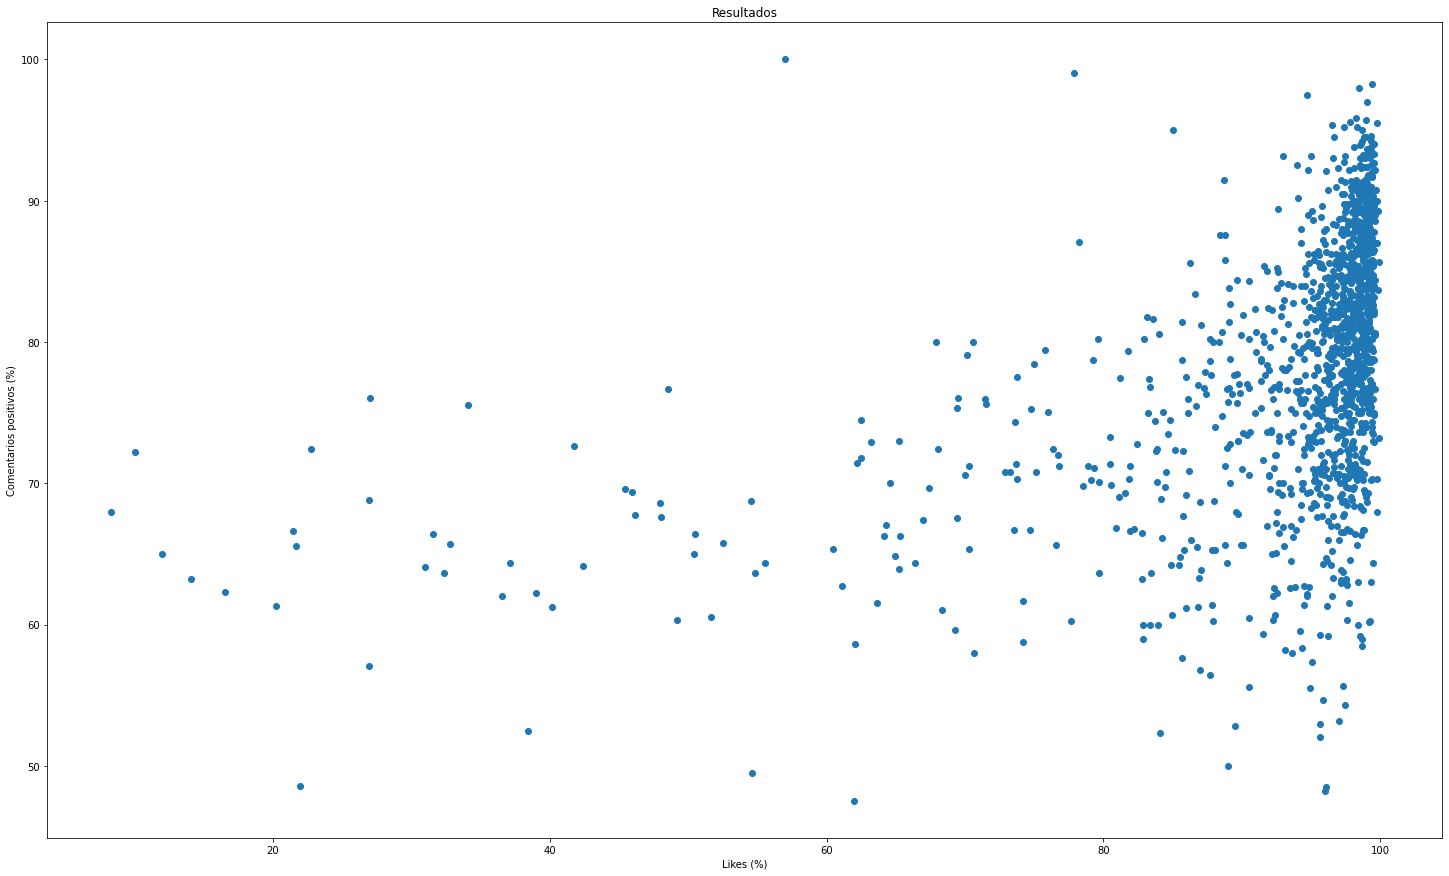

In [26]:
# Despliega el porcentaje de comentarios positivos comparado al porcentaje de likes
X = dfFinal["Likes (%)"].values.tolist()
Y = dfFinal["Positivos (%)"].values.tolist()
plt.plot(X,Y,"o")
plt.xlabel('Likes (%)')
plt.ylabel('Comentarios positivos (%)')
plt.title('Resultados')
plt.rcParams['figure.figsize'] = [25, 10]
plt.show()
